# EDA and Data Visualization (Daily Trends)

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [174]:
# Load data for building 5
df = pd.read_csv("../data/preprocessed/Building_5.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [175]:
df.head()

,month,hour,day_type,daylight_savings,indoor_temp,avg_unmet_cooling_temp,indoor_hum,equipment_electric_power_kWh,dhw_heating_kWh,cooling_load_kWh,...,pred_24h_outdoor_hum,pred_6h_diffuse_solar_W_m2,pred_12h_diffuse_solar_W_m2,pred_24h_diffuse_solar_W_m2,pred_6h_direct_solar_W_m2,pred_12h_direct_solar_W_m2,pred_24h_direct_solar_W_m2,holiday,workday,solar_generation_kW
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-02 00:00:00,1,1,8,0,22.02,0.0,55.86,11.7,3.00,1.61,...,91.65,-0.00,170.84,0.0,-0.00,5.32,0.0,True,False,0.0
2008-01-02 01:00:00,1,2,8,0,21.78,0.0,52.90,7.2,3.36,0.47,...,101.62,16.77,112.24,0.0,1.11,2.04,-0.0,True,False,0.0
2008-01-02 02:00:00,1,3,8,0,21.77,0.0,50.06,8.1,0.36,0.58,...,105.77,40.08,65.93,0.0,1.74,1.04,0.0,True,False,0.0
2008-01-02 03:00:00,1,4,8,0,21.81,0.0,47.95,12.4,0.12,1.19,...,92.80,65.63,38.59,-0.0,1.09,0.99,0.0,True,False,0.0
2008-01-02 04:00:00,1,5,8,0,21.77,0.0,46.91,8.6,0.00,0.59,...,100.62,107.26,15.92,0.0,1.78,0.84,0.0,True,False,0.0


In [176]:
# Add a total load
df['total_load_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh'] + df['cooling_load_kWh']

# Add a total load
df['total_load_wo_cooling_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh']

In [177]:
# Group by workdays in Jan and Jul
df_workday_jan = df[(df.index.month == 1) & (df.workday == True)]
df_workday_jul = df[(df.index.month == 7) & (df.workday == True)]

# Group by weekends/holidays in Jan and Jul
df_weekend_jan = df[(df.index.month == 1) & (df.workday == False)]
df_weekend_jul = df[(df.index.month == 7) & (df.workday == False)]

### Energy demand and solar generation in Jan vs Jul for workdays

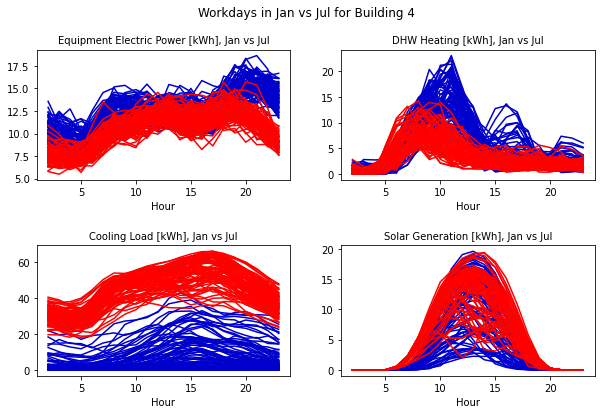

In [178]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

plt.subplot(2, 2, 1)
col = "equipment_electric_power_kWh"
for idx, day in df_workday_jan.groupby(df_workday_jan.index.date):
    df_plot1 = df_workday_jan[df_workday_jan.index.date == idx].reset_index().rolling(3).mean()
    ax[0,0].plot(col, data=df_plot1, label=idx, color="mediumblue")

for idx, day in df_workday_jul.groupby(df_workday_jul.index.date):
    df_plot1 = df_workday_jul[df_workday_jul.index.date == idx].reset_index().rolling(3).mean()
    ax[0,0].plot(col, data=df_plot1, label=idx, color="red")
ax[0,0].set_title('Equipment Electric Power [kWh], Jan vs Jul',fontsize=10)
ax[0,0].set_xlabel("Hour", fontsize=10)

plt.subplot(2, 2, 2)
col = "dhw_heating_kWh"
for idx, day in df_workday_jan.groupby(df_workday_jan.index.date):
    df_plot2 = df_workday_jan[df_workday_jan.index.date == idx].reset_index().rolling(3).mean()
    ax[0,1].plot(col, data=df_plot2, label=idx, color="mediumblue")

for idx, day in df_workday_jul.groupby(df_workday_jul.index.date):
    df_plot2 = df_workday_jul[df_workday_jul.index.date == idx].reset_index().rolling(3).mean()
    ax[0,1].plot(col, data=df_plot2, label=idx, color="red")
ax[0,1].set_title('DHW Heating [kWh], Jan vs Jul',fontsize=10)
ax[0,1].set_xlabel("Hour", fontsize=10)

plt.subplot(2, 2, 3)
col="cooling_load_kWh"
for idx, day in df_workday_jan.groupby(df_workday_jan.index.date):
    df_plot3 = df_workday_jan[df_workday_jan.index.date == idx].reset_index().rolling(3).mean()
    ax[1,0].plot(col, data=df_plot3, label=idx, color="mediumblue")

for idx, day in df_workday_jul.groupby(df_workday_jul.index.date):
    df_plot3 = df_workday_jul[df_workday_jul.index.date == idx].reset_index().rolling(3).mean()
    ax[1,0].plot(col, data=df_plot3, label=idx, color="red")
ax[1,0].set_title('Cooling Load [kWh], Jan vs Jul',fontsize=10)
ax[1,0].set_xlabel("Hour", fontsize=10)

plt.subplot(2, 2, 4)
col = "solar_generation_kW"
for idx, day in df_workday_jan.groupby(df_workday_jan.index.date):
    df_plot4 = df_workday_jan[df_workday_jan.index.date == idx].reset_index().rolling(3).mean()
    ax[1,1].plot(col, data=df_plot4, label=idx, color="mediumblue")

for idx, day in df_workday_jul.groupby(df_workday_jul.index.date):
    df_plot4 = df_workday_jul[df_workday_jul.index.date == idx].reset_index().rolling(3).mean()
    ax[1,1].plot(col, data=df_plot4, label=idx, color="red")
ax[1,1].set_title('Solar Generation [kWh], Jan vs Jul',fontsize=10)
ax[1,1].set_xlabel("Hour", fontsize=10)

fig.suptitle('Workdays in Jan vs Jul for Building 4')
plt.subplots_adjust(hspace = 0.5)

plt.show()


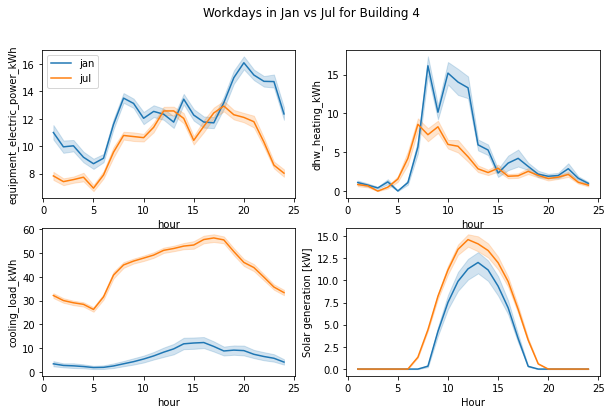

In [179]:
fig, ax = plt.subplots(2,2,figsize=(10,6))
plt.subplot(2, 2, 1)
col = "equipment_electric_power_kWh"
sns.lineplot(data=df_workday_jan, y=col, x='hour', label="jan")
sns.lineplot(data=df_workday_jul, y=col, x='hour', label="jul")
plt.legend()

plt.subplot(2, 2, 2)
col = "dhw_heating_kWh"
sns.lineplot(data=df_workday_jan, y=col, x='hour')
sns.lineplot(data=df_workday_jul, y=col, x='hour')

plt.subplot(2, 2, 3)
col = "cooling_load_kWh"
sns.lineplot(data=df_workday_jan, y=col, x='hour')
sns.lineplot(data=df_workday_jul, y=col, x='hour')

plt.subplot(2, 2, 4)
col = "solar_generation_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour')
sns.lineplot(data=df_workday_jul, y=col, x='hour')
plt.ylabel('Solar generation [kW]')
plt.xlabel('Hour')


fig.suptitle('Workdays in Jan vs Jul for Building 4')

plt.show()



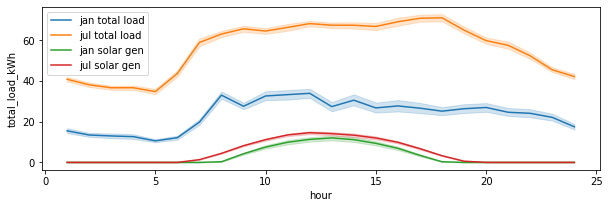

In [180]:
fig, ax = plt.subplots(figsize=(10,3))
#plt.subplot(1, 2, 1)
col = "total_load_kWh"
sns.lineplot(data=df_workday_jan, y=col, x='hour', label="jan total load")
sns.lineplot(data=df_workday_jul, y=col, x='hour', label="jul total load")

#plt.subplot(1, 2, 2)
col = "solar_generation_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour', label="jan solar gen")
sns.lineplot(data=df_workday_jul, y=col, x='hour', label="jul solar gen")
plt.legend()

# plt.subplot(2, 2, 3)
# col = "cooling_load_kWh"
# sns.lineplot(data=df_workday_jan, y=col, x='hour')
# sns.lineplot(data=df_workday_jul, y=col, x='hour')

# plt.subplot(2, 2, 4)
# col = "solar_generation_kW"
# sns.lineplot(data=df_workday_jan, y=col, x='hour')
# sns.lineplot(data=df_workday_jul, y=col, x='hour')

In [194]:
df.query('solar_generation_kW > total_load_kWh').shape

(113, 32)

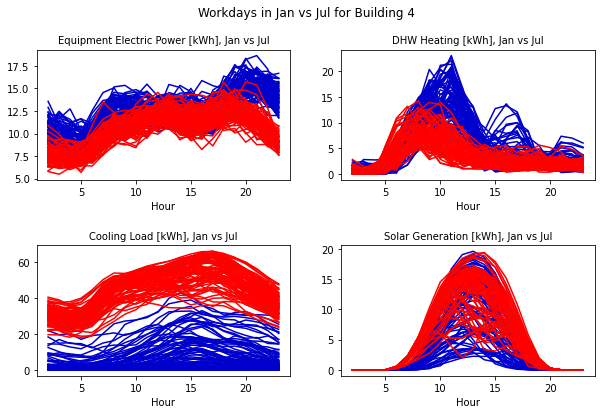

In [182]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

plt.subplot(2, 2, 1)
col = "equipment_electric_power_kWh"
for idx, day in df_workday_jan.groupby(df_workday_jan.index.date):
    df_plot1 = df_workday_jan[df_workday_jan.index.date == idx].reset_index().rolling(3).mean()
    ax[0,0].plot(col, data=df_plot1, label=idx, color="mediumblue")

for idx, day in df_workday_jul.groupby(df_workday_jul.index.date):
    df_plot1 = df_workday_jul[df_workday_jul.index.date == idx].reset_index().rolling(3).mean()
    ax[0,0].plot(col, data=df_plot1, label=idx, color="red")
ax[0,0].set_title('Equipment Electric Power [kWh], Jan vs Jul',fontsize=10)
ax[0,0].set_xlabel("Hour", fontsize=10)

plt.subplot(2, 2, 2)
col = "dhw_heating_kWh"
for idx, day in df_workday_jan.groupby(df_workday_jan.index.date):
    df_plot2 = df_workday_jan[df_workday_jan.index.date == idx].reset_index().rolling(3).mean()
    ax[0,1].plot(col, data=df_plot2, label=idx, color="mediumblue")

for idx, day in df_workday_jul.groupby(df_workday_jul.index.date):
    df_plot2 = df_workday_jul[df_workday_jul.index.date == idx].reset_index().rolling(3).mean()
    ax[0,1].plot(col, data=df_plot2, label=idx, color="red")
ax[0,1].set_title('DHW Heating [kWh], Jan vs Jul',fontsize=10)
ax[0,1].set_xlabel("Hour", fontsize=10)

plt.subplot(2, 2, 3)
col="cooling_load_kWh"
for idx, day in df_workday_jan.groupby(df_workday_jan.index.date):
    df_plot3 = df_workday_jan[df_workday_jan.index.date == idx].reset_index().rolling(3).mean()
    ax[1,0].plot(col, data=df_plot3, label=idx, color="mediumblue")

for idx, day in df_workday_jul.groupby(df_workday_jul.index.date):
    df_plot3 = df_workday_jul[df_workday_jul.index.date == idx].reset_index().rolling(3).mean()
    ax[1,0].plot(col, data=df_plot3, label=idx, color="red")
ax[1,0].set_title('Cooling Load [kWh], Jan vs Jul',fontsize=10)
ax[1,0].set_xlabel("Hour", fontsize=10)

plt.subplot(2, 2, 4)
col = "solar_generation_kW"
for idx, day in df_workday_jan.groupby(df_workday_jan.index.date):
    df_plot4 = df_workday_jan[df_workday_jan.index.date == idx].reset_index().rolling(3).mean()
    ax[1,1].plot(col, data=df_plot4, label=idx, color="mediumblue")

for idx, day in df_workday_jul.groupby(df_workday_jul.index.date):
    df_plot4 = df_workday_jul[df_workday_jul.index.date == idx].reset_index().rolling(3).mean()
    ax[1,1].plot(col, data=df_plot4, label=idx, color="red")
ax[1,1].set_title('Solar Generation [kWh], Jan vs Jul',fontsize=10)
ax[1,1].set_xlabel("Hour", fontsize=10)

fig.suptitle('Workdays in Jan vs Jul for Building 4')
plt.subplots_adjust(hspace = 0.5)

plt.show()


### Average energy demand and generation for Jan and Jul, workdays and weekends

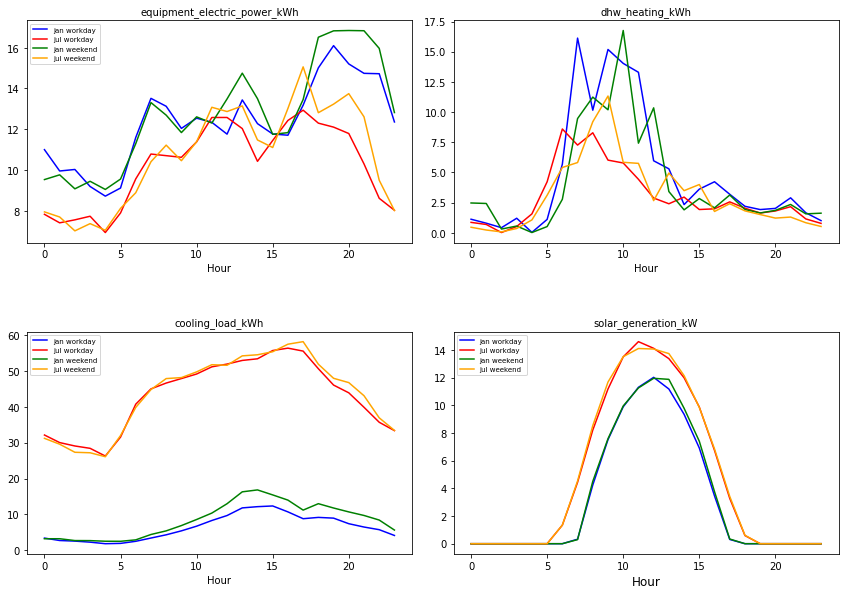

In [183]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
fig.tight_layout()
plt.subplot(2, 2, 1)
col = "equipment_electric_power_kWh"
ax[0,0] = df_workday_jan.groupby(df_workday_jan.index.hour)[col].mean().plot(label="jan workday", color="blue")
ax[0,0] = df_workday_jul.groupby(df_workday_jul.index.hour)[col].mean().plot(label="jul workday", color="red")
ax[0,0] = df_weekend_jan.groupby(df_weekend_jan.index.hour)[col].mean().plot(label="jan weekend", color="green")
ax[0,0] = df_weekend_jul.groupby(df_weekend_jul.index.hour)[col].mean().plot(label="jul weekend", color="orange")
ax[0,0].set_title(col, fontsize=10)
ax[0,0].set_xlabel("Hour", fontsize=10)
ax[0,0].legend(fontsize=7, loc='upper left')

plt.subplot(2, 2, 2)
col = "dhw_heating_kWh"
ax[0,1] = df_workday_jan.groupby(df_workday_jan.index.hour)[col].mean().plot(label="jan workday", color="blue")
ax[0,1] = df_workday_jul.groupby(df_workday_jul.index.hour)[col].mean().plot(label="jul workday", color="red")
ax[0,1] = df_weekend_jan.groupby(df_weekend_jan.index.hour)[col].mean().plot(label="jan weekend", color="green")
ax[0,1] = df_weekend_jul.groupby(df_weekend_jul.index.hour)[col].mean().plot(label="jul weekend", color="orange")
ax[0,1].set_title(col, fontsize=10)
ax[0,1].set_xlabel("Hour", fontsize=10)
# ax[0,1].legend(fontsize=7, loc='upper right')

plt.subplot(2, 2, 3)
col = "cooling_load_kWh"
ax[1,0] = df_workday_jan.groupby(df_workday_jan.index.hour)[col].mean().plot(label="jan workday", color="blue")
ax[1,0] = df_workday_jul.groupby(df_workday_jul.index.hour)[col].mean().plot(label="jul workday", color="red")
ax[1,0] = df_weekend_jan.groupby(df_weekend_jan.index.hour)[col].mean().plot(label="jan weekend", color="green")
ax[1,0] = df_weekend_jul.groupby(df_weekend_jul.index.hour)[col].mean().plot(label="jul weekend", color="orange")
ax[1,0].legend(fontsize=7, loc='upper left')
ax[1,0].set_xlabel("Hour", fontsize=10)
ax[1,0].set_title(col, fontsize=10)

plt.subplot(2, 2, 4)
col = "solar_generation_kW"
ax[1,1] = df_workday_jan.groupby(df_workday_jan.index.hour)[col].mean().plot(label="jan workday", color="blue")
ax[1,1] = df_workday_jul.groupby(df_workday_jul.index.hour)[col].mean().plot(label="jul workday", color="red")
ax[1,1] = df_weekend_jan.groupby(df_weekend_jan.index.hour)[col].mean().plot(label="jan weekend", color="green")
ax[1,1] = df_weekend_jul.groupby(df_weekend_jul.index.hour)[col].mean().plot(label="jul weekend", color="orange")
ax[1,1].set_title(col, fontsize=10)
ax[1,1].set_xlabel("Hour", fontsize=12)
ax[1,1].legend(fontsize=7, loc='upper left')

#fig.suptitle('Average energy demand on workdays for Building 4 (strip mall retail)')
plt.subplots_adjust(hspace = 0.4)
plt.show()

### Average total load by month for Building 4 (with cooling)

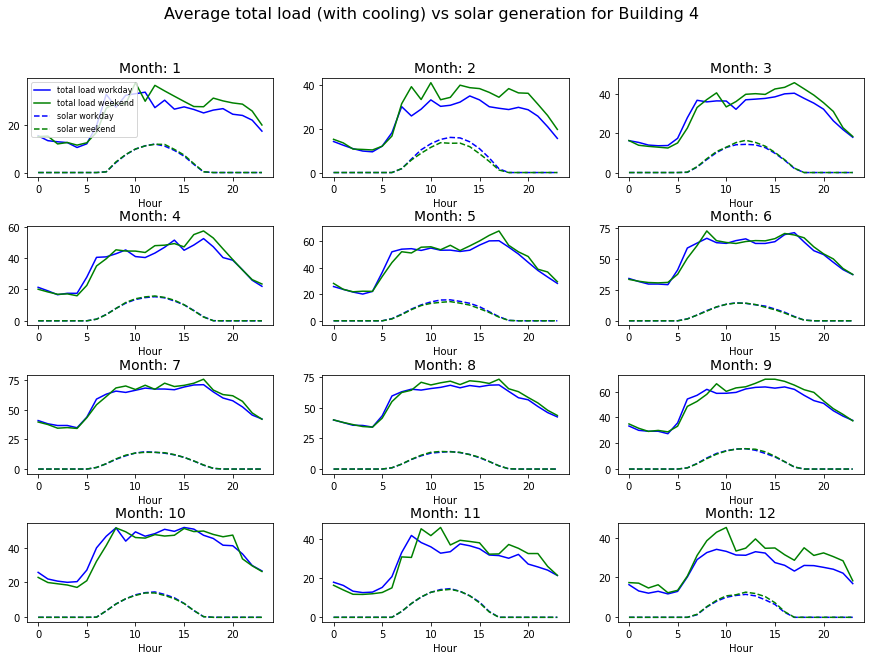

In [184]:
fig, ax = plt.subplots(4, 3, figsize=(15,10))

for month in range(1,13):

    # Group by workdays
    df_workday = df[(df.index.month == month) & (df.workday == True)]

    # Group by weekends/holidays
    df_weekend = df[(df.index.month == month) & (df.workday == False)]

    plt.subplot(4, 3, month)
    col = "total_load_kWh"
    df_workday.groupby(df_workday.index.hour)[col].mean().plot(label="total load workday", color="blue")
    df_weekend.groupby(df_weekend.index.hour)[col].mean().plot(label="total load weekend", color="green")

    col = "solar_generation_kW"
    df_workday.groupby(df_workday.index.hour)[col].mean().plot(label="solar workday", color="blue", linestyle='--')
    df_weekend.groupby(df_weekend.index.hour)[col].mean().plot(label="solar weekend", color="green", linestyle='--')
    plt.xlabel('Hour')
    if month == 1:
        plt.legend(fontsize=8)
    plt.title('Month: '+str(month), fontsize=14)
fig.suptitle('Average total load (with cooling) vs solar generation for Building 4', fontsize=16)
plt.subplots_adjust(hspace=0.5)
plt.show()

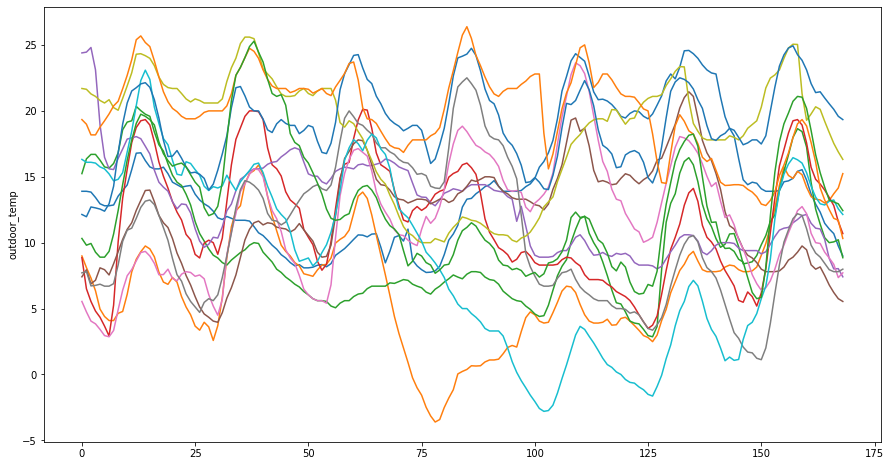

In [185]:
fig, ax = plt.subplots(figsize=(15,8))
datarange_list = pd.date_range(start='2008-07', end='2011-08', freq='W-MON')
#plt.subplot(2, 1, 1)
for date in datarange_list:
    dates = pd.date_range(start=date, end=date+timedelta(days=7), freq='H')
    if dates[-1].month == 1:
        df_plot = df.loc[dates[0]:dates[-1]]
        #df_plot.reset_index()['total_load_kWh'].plot()
        #df_plot.reset_index()['outdoor_temp'].plot()
        sns.lineplot(data=df_plot, y='outdoor_temp', x=np.arange(0,24*7+1), ci=95)

        #df_plot.reset_index()['holiday'].mul(30).plot()
        
# datarange_list = pd.date_range(start='2008-01', end='2011-02', freq='W-MON')
# for date in datarange_list:
#     dates = pd.date_range(start=date, end=date+timedelta(days=7), freq='H')
#     if dates[-1].month == 7:
#         df_plot = df.loc[dates[0]:dates[-1]]
#         df_plot.reset_index()['total_load_kWh'].plot(linestyle='--')

# plt.subplot(2, 1, 2)
# for date in datarange_list:
#     dates = pd.date_range(start=date, end=date+timedelta(days=7), freq='H')
#     if dates[-1].month == 1:
#         df_plot = df.loc[dates[0]:dates[-1]]
#         df_plot.reset_index()['outdoor_temp'].plot()

# datarange_list = pd.date_range(start='2008-01', end='2011-02', freq='W-MON')
# for date in datarange_list:
#     dates = pd.date_range(start=date, end=date+timedelta(days=7), freq='H')
#     if dates[-1].month == 7:
#         df_plot = df.loc[dates[0]:dates[-1]]
#         df_plot.reset_index()['outdoor_temp'].plot(linestyle='--')

<AxesSubplot:xlabel='outdoor_temp', ylabel='total_load_kWh'>

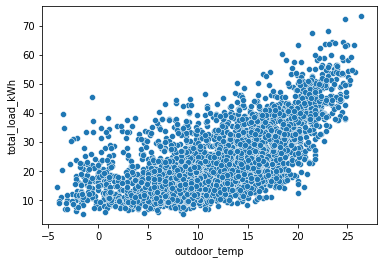

In [186]:
df_month = df[df.index.month == 1]
sns.scatterplot(x="outdoor_temp", y="total_load_kWh", data=df_month)

<AxesSubplot:xlabel='outdoor_temp', ylabel='total_load_kWh'>

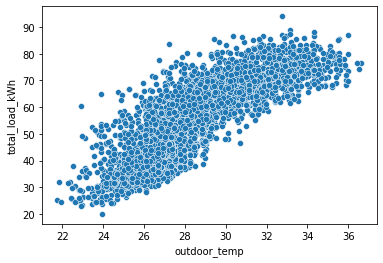

In [187]:
df_month = df[df.index.month == 7]
sns.scatterplot(x="outdoor_temp", y="total_load_kWh", data=df_month)

In [188]:
df[['outdoor_temp', 'outdoor_hum','cooling_load_kWh','total_load_kWh', 'solar_generation_kW', 'holiday']].corr()

,outdoor_temp,outdoor_hum,cooling_load_kWh,total_load_kWh,solar_generation_kW,holiday
outdoor_temp,1.000000,-0.081113,0.907517,0.822930,0.288118,-0.024990
outdoor_hum,-0.081113,1.000000,-0.190609,-0.229548,-0.543710,0.016835
cooling_load_kWh,0.907517,-0.190609,1.000000,0.949430,0.362005,-0.020028
total_load_kWh,0.822930,-0.229548,0.949430,1.000000,0.429550,-0.013974
solar_generation_kW,0.288118,-0.543710,0.362005,0.429550,1.000000,-0.008373
holiday,-0.024990,0.016835,-0.020028,-0.013974,-0.008373,1.000000


<AxesSubplot:xlabel='datetime'>

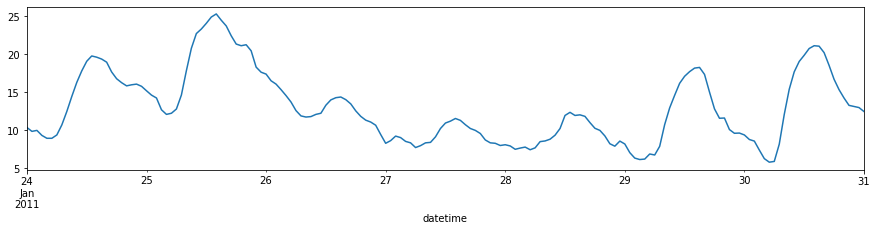

In [189]:
fig, ax = plt.subplots(figsize=(15,3))
df_plot['outdoor_temp'].plot()

<AxesSubplot:xlabel='datetime'>

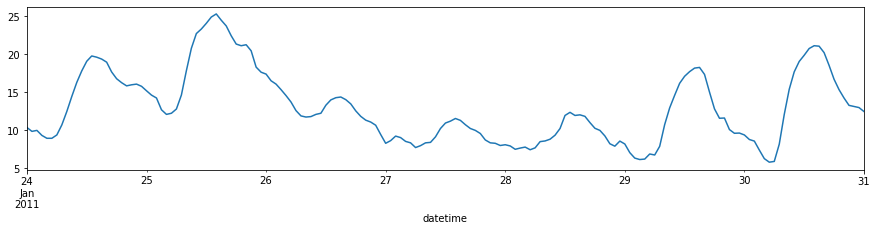

In [190]:
fig, ax = plt.subplots(figsize=(15,3))
df_plot['outdoor_temp'].plot()

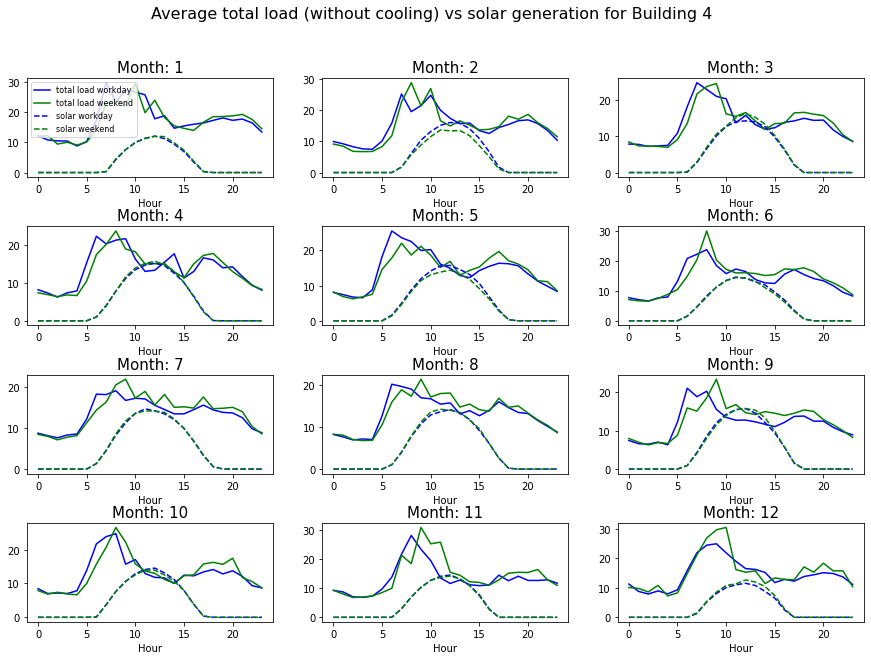

In [191]:
fig, ax = plt.subplots(4, 3, figsize=(15,10))

for month in range(1,13):

    # Group by workdays
    df_workday = df[(df.index.month == month) & (df.workday == True)]

    # Group by weekends/holidays
    df_weekend = df[(df.index.month == month) & (df.workday == False)]

    plt.subplot(4, 3, month)
    col = "total_load_wo_cooling_kWh"
    df_workday.groupby(df_workday.index.hour)[col].mean().plot(label="total load workday", color="blue")
    df_weekend.groupby(df_weekend.index.hour)[col].mean().plot(label="total load weekend", color="green")

    col = "solar_generation_kW"
    df_workday.groupby(df_workday.index.hour)[col].mean().plot(label="solar workday", color="blue", linestyle='--')
    df_weekend.groupby(df_weekend.index.hour)[col].mean().plot(label="solar weekend", color="green", linestyle='--')
    plt.xlabel('Hour')
    if month == 1:
        plt.legend(fontsize=8)
    plt.title('Month: '+str(month), fontsize=15)
fig.suptitle('Average total load (without cooling) vs solar generation for Building 4', fontsize=16)
plt.subplots_adjust(hspace=0.5)
plt.show()